# Import libraries and setup

In [1]:
import sys, os, csv, importlib

In [2]:
import numpy as np
import scipy as sc
import scipy.linalg as spl
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import scipy.stats as stats
import random

import itertools

from bt_cpd import *

from datetime import datetime
import time
import bisect

import statsmodels.api as sm
from sklearn import linear_model

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [5]:
def bt_fit(y, X, lam):
    y = y.reshape((-1,))
    if 0 not in y or 1 not in y:
        return np.zeros((X.shape[1], 1))

    logit = linear_model.LogisticRegression(fit_intercept = False, penalty = 'l2', solver = 'lbfgs',
                                            C = 1/lam, random_state = 0, max_iter = 50)
    logit.fit(X, y)
    beta_hat = logit.coef_
    return beta_hat.reshape((-1,1))

In [10]:
all_games = pd.read_csv("nba/nba_games.csv")

In [11]:
len(all_games)

112808

In [12]:
all_games.columns

Index(['season', 'game_id', 'team_A_id', 'team_A_city', 'team_A_name',
       'team_A_pts', 'team_A_fta', 'team_A_ftm', 'team_B_id', 'team_B_city',
       'team_B_name', 'team_B_pts', 'team_B_fta', 'team_B_ftm'],
      dtype='object')

In [13]:
all_games.head()

,season,game_id,team_A_id,team_A_city,team_A_name,team_A_pts,team_A_fta,team_A_ftm,team_B_id,team_B_city,team_B_name,team_B_pts,team_B_fta,team_B_ftm
0,1949-50,24900558,1610610037,Waterloo,Hawks,79,31.0,23.0,1610612737,Tri-Cities,Blackhawks,77,27.0,21.0
1,1949-50,24900553,1610612737,Tri-Cities,Blackhawks,88,38.0,28.0,1610612755,Syracuse,Nationals,89,33.0,23.0
2,1949-50,24900529,1610612737,Tri-Cities,Blackhawks,97,34.0,23.0,1610610033,Sheboygan,Redskins,79,36.0,27.0
3,1949-50,24900515,1610612737,Tri-Cities,Blackhawks,67,38.0,27.0,1610610023,Anderson,Packers,82,43.0,30.0
4,1949-50,24900508,1610610023,Anderson,Packers,88,33.0,26.0,1610612737,Tri-Cities,Blackhawks,77,22.0,19.0


In [15]:
len(np.unique(all_games['game_id'].values))

56430

In [16]:
all_games[all_games['game_id'] == 24900558]

,season,game_id,team_A_id,team_A_city,team_A_name,team_A_pts,team_A_fta,team_A_ftm,team_B_id,team_B_city,team_B_name,team_B_pts,team_B_fta,team_B_ftm
0,1949-50,24900558,1610610037,Waterloo,Hawks,79,31.0,23.0,1610612737,Tri-Cities,Blackhawks,77,27.0,21.0
5476,1949-50,24900558,1610610037,Waterloo,Hawks,79,31.0,23.0,1610612737,Tri-Cities,Blackhawks,77,27.0,21.0


Check duplicates

In [17]:
game_ids = np.unique(all_games['game_id'].values)

In [20]:
single_id = []
mistake_id = []
more_dup_id = []
for i in game_ids:
    sub = all_games[all_games['game_id'] == i]
    if len(sub) == 1:
        single_id.append(i)
    if len(sub) > 2:
        more_dup_id.append(i)
    if len(sub) == 2:
        pts_1 = (sub['team_A_pts'].values[0],sub['team_B_pts'].values[0])
        pts_2 = (sub['team_A_pts'].values[1],sub['team_B_pts'].values[1])
        if pts_1 != pts_2:
            mistake_id.append(i)

In [21]:
print(len(single_id))
print(len(mistake_id))
print(len(more_dup_id))

590
0
533


In [22]:
ix = more_dup_id[0]
all_games[all_games['game_id'] == ix]

,season,game_id,team_A_id,team_A_city,team_A_name,team_A_pts,team_A_fta,team_A_ftm,team_B_id,team_B_city,team_B_name,team_B_pts,team_B_fta,team_B_ftm
11018,2012-13,21201216,1610612761,Toronto,Raptors,114,28.0,22.0,1610612738,Boston,Celtics,90,13.0,9.0
11019,2012-13,21201216,1610612761,Toronto,Raptors,114,28.0,22.0,1610612738,Boston,Celtics,90,13.0,9.0
85078,2012-13,21201216,1610612761,Toronto,Raptors,114,28.0,22.0,1610612738,Boston,Celtics,90,13.0,9.0


In [ ]:
ix = more_dup_id[0]
all_games[all_games['game_id'] == ix]

In [26]:
year = '2012-13'
all_games[all_games['season'] == year]

,season,game_id,team_A_id,team_A_city,team_A_name,team_A_pts,team_A_fta,team_A_ftm,team_B_id,team_B_city,team_B_name,team_B_pts,team_B_fta,team_B_ftm
4980,2012-13,21201218,1610612752,New York,Knicks,98,16.0,11.0,1610612737,Atlanta,Hawks,92,17.0,16.0
4981,2012-13,21201213,1610612761,Toronto,Raptors,113,27.0,23.0,1610612737,Atlanta,Hawks,96,23.0,17.0
4982,2012-13,21201179,1610612749,Milwaukee,Bucks,104,16.0,11.0,1610612737,Atlanta,Hawks,109,25.0,17.0
4983,2012-13,21201164,1610612755,Philadelphia,76ers,101,22.0,20.0,1610612737,Atlanta,Hawks,124,19.0,18.0
4984,2012-13,21201143,1610612759,San Antonio,Spurs,99,29.0,24.0,1610612737,Atlanta,Hawks,97,25.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111224,2012-13,21200063,1610612758,Sacramento,Kings,105,24.0,18.0,1610612765,Detroit,Pistons,103,31.0,23.0
111225,2012-13,21200048,1610612758,Sacramento,Kings,94,23.0,16.0,1610612744,Golden State,Warriors,92,28.0,24.0
111226,2012-13,21200028,1610612758,Sacramento,Kings,98,20.0,16.0,1610612754,Indiana,Pacers,106,27.0,24.0
111227,2012-13,21200023,1610612758,Sacramento,Kings,80,16.0,13.0,1610612750,Minnesota,Timberwolves,92,36.0,26.0


In [28]:
len(np.unique(all_games[all_games['season'] == year]['game_id'].values))

1229

In [64]:
all_games = all_games.drop_duplicates(subset = ['game_id'], keep = 'first', ignore_index = True).reset_index(drop = True)

In [65]:
all_games = all_games.sort_values(by = ['season', 'game_id'])

In [66]:
all_games

,season,game_id,team_A_id,team_A_city,team_A_name,team_A_pts,team_A_fta,team_A_ftm,team_B_id,team_B_city,team_B_name,team_B_pts,team_B_fta,team_B_ftm
0,1946-47,24600001,1610610035,Toronto,Huskies,66,29.0,16.0,1610612752,New York,Knicks,68,26.0,20.0
1,1946-47,24600002,1610610032,Providence,Steamrollers,59,NaN,17.0,1610612738,Boston,Celtics,53,NaN,11.0
2,1946-47,24600003,1610610034,St. Louis,Bombers,56,NaN,16.0,1610610031,Pittsburgh,Ironmen,51,NaN,19.0
3,1946-47,24600004,1610610025,Chicago,Stags,63,NaN,21.0,1610612752,New York,Knicks,47,NaN,15.0
4,1946-47,24600005,1610610028,Detroit,Falcons,33,NaN,13.0,1610610036,Washington,Capitols,50,NaN,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56425,2015-16,21501226,1610612740,New Orleans,Pelicans,109,22.0,18.0,1610612750,Minnesota,Timberwolves,144,23.0,19.0
56426,2015-16,21501227,1610612763,Memphis,Grizzlies,104,16.0,12.0,1610612744,Golden State,Warriors,125,16.0,13.0
56427,2015-16,21501228,1610612762,Utah,Jazz,96,15.0,9.0,1610612747,Los Angeles,Lakers,101,15.0,13.0
56428,2015-16,21501229,1610612756,Phoenix,Suns,114,22.0,17.0,1610612746,LA,Clippers,105,12.0,10.0


In [165]:
all_teams = np.unique(np.concatenate([all_games['team_A_name'].values, all_games['team_B_name'].values]))
len(all_teams)

50

In [166]:
ix_for_teams = [i for i in range(len(all_games)) if all_games['team_A_name'][i] in all_teams and 
                all_games['team_B_name'][i] in all_teams]

In [167]:
len(ix_for_teams)

56430

In [168]:
team_games = all_games.loc[ix_for_teams,].reset_index(drop = True)[['season', 'game_id','team_A_name',
                                                                   'team_B_name','team_A_pts','team_B_pts']]

In [169]:
t1 = team_games[['season','team_A_name']].groupby(by = 'team_A_name').agg(['min','max']).reset_index()
t1.columns = ['team', 'min_season', 'max_season']

t2 = team_games[['season','team_B_name']].groupby(by = 'team_B_name').agg(['min','max']).reset_index()
t2.columns = ['team', 'min_season', 'max_season']

all_teams_history = pd.concat([t1,t2]).groupby(by = 'team').min().reset_index()
all_teams_history

,team,min_season,max_season
0,76ers,1963-64,2015-16
1,Blackhawks,1949-50,1950-51
2,Bobcats,2004-05,2013-14
3,Bombers,1946-47,1949-50
4,Braves,1970-71,1977-78
5,Bucks,1968-69,2015-16
6,Bullets,1947-48,1995-96
7,Bulls,1966-67,2015-16
8,Capitols,1946-47,1950-51
9,Cavaliers,1970-71,2015-16


In [170]:
teams_ix = np.where(np.logical_and(all_teams_history['min_season'].values < '1990', 
                                   all_teams_history['max_season'].values > '2014'))[0]
print(len(teams_ix))
teams = all_teams_history['team'].values[teams_ix]
rm = []
teams = [t for t in teams if t not in rm]
print(len(teams))
teams

24
24


['76ers',
 'Bucks',
 'Bulls',
 'Cavaliers',
 'Celtics',
 'Clippers',
 'Heat',
 'Hornets',
 'Jazz',
 'Kings',
 'Knicks',
 'Lakers',
 'Magic',
 'Mavericks',
 'Nets',
 'Nuggets',
 'Pacers',
 'Pistons',
 'Rockets',
 'Spurs',
 'Suns',
 'Timberwolves',
 'Trail Blazers',
 'Warriors']

In [172]:
ix_for_teams = [i for i in range(len(all_games)) if all_games['team_A_name'][i] in teams and 
                all_games['team_B_name'][i] in teams]

In [173]:
len(ix_for_teams)

35423

In [174]:
ix_team_time = [i for i in range(len(all_games)) if all_games['team_A_name'][i] in teams and 
                all_games['team_B_name'][i] in teams and all_games['season'][i] > '1980']
len(ix_team_time)

27736

In [175]:
games = all_games.iloc[ix_team_time].reset_index(drop = True)[['season', 'game_id','team_A_name',
                                                                   'team_B_name','team_A_pts','team_B_pts']]

In [176]:
len(games)

27736

In [177]:
games

,season,game_id,team_A_name,team_B_name,team_A_pts,team_B_pts
0,1980-81,28000001,Suns,Warriors,121,101
1,1980-81,28000002,Nuggets,Spurs,112,113
2,1980-81,28000003,76ers,Bucks,103,106
3,1980-81,28000004,Clippers,Rockets,120,104
4,1980-81,28000008,Jazz,Trail Blazers,96,86
...,...,...,...,...,...,...
27731,2015-16,21501224,Kings,Rockets,81,116
27732,2015-16,21501225,Bucks,Pacers,92,97
27733,2015-16,21501228,Jazz,Lakers,96,101
27734,2015-16,21501229,Suns,Clippers,114,105


In [178]:
t1 = games[['season','team_A_name']].groupby(by = 'team_A_name').agg(['min','max']).reset_index()
t1.columns = ['team', 'min_season', 'max_season']

t2 = games[['season','team_B_name']].groupby(by = 'team_B_name').agg(['min','max']).reset_index()
t2.columns = ['team', 'min_season', 'max_season']

teams_history = pd.concat([t1,t2]).groupby(by = 'team').min().reset_index()
teams_history

,team,min_season,max_season
0,76ers,1980-81,2015-16
1,Bucks,1980-81,2015-16
2,Bulls,1980-81,2015-16
3,Cavaliers,1980-81,2015-16
4,Celtics,1980-81,2015-16
5,Clippers,1980-81,2015-16
6,Heat,1988-89,2015-16
7,Hornets,1988-89,2015-16
8,Jazz,1980-81,1995-96
9,Kings,1980-81,2015-16


In [179]:
teams = teams_history['team'].values

In [180]:
team_to_id = {teams[i]:i for i in range(len(teams))}
print(len(teams))

24


In [181]:
T = len(games)
p = len(teams)
X = np.zeros((T,p))
Y = np.zeros(T)
for i in range(T):
    cur = games.loc[i,]
    t = [team_to_id[cur['team_A_name']],team_to_id[cur['team_B_name']]]
    t1, t2 = t
    X[i, t1] = 1
    X[i, t2] = -1
    if cur['team_A_pts'] > cur['team_B_pts']:
        Y[i] = 1
    else:
        Y[i] = 0

In [182]:
lam = 0.1
beta_all = bt_fit(Y, X, lam).reshape((-1,))

In [183]:
score_all = pd.DataFrame({'team':teams, 'theta_all':beta_all}).sort_values(by = 'theta_all', ascending=False)
score_all

,team,theta_all
11,Lakers,0.520348
19,Spurs,0.500588
8,Jazz,0.268228
22,Trail Blazers,0.257066
20,Suns,0.247791
18,Rockets,0.199145
4,Celtics,0.195587
2,Bulls,0.082627
17,Pistons,0.038917
13,Mavericks,0.033090


## Fit BTL for each season and check the path

In [231]:
all_seasons = np.unique(games['season'].values)
all_seasons

array(['1980-81', '1981-82', '1982-83', '1983-84', '1984-85', '1985-86',
       '1986-87', '1987-88', '1988-89', '1989-90', '1990-91', '1991-92',
       '1992-93', '1993-94', '1994-95', '1995-96', '1996-97', '1997-98',
       '1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04',
       '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10',
       '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16'],
      dtype=object)

In [242]:
n = len(teams)
T = len(all_seasons)
beta_season = np.zeros((T, n))

lam = 0.1
for i, s in enumerate(all_seasons):
    ix = np.where(games['season'].values == s)[0]
    print(s + ': ' + str(len(ix)))
    Y_cur = Y[ix]
    X_cur = X[ix]
    beta_cur = bt_fit(Y_cur, X_cur, lam).reshape((-1,))
    beta_season[i] = beta_cur.copy()

1980-81: 705
1981-82: 706
1982-83: 707
1983-84: 707
1984-85: 707
1985-86: 706
1986-87: 706
1987-88: 707
1988-89: 787
1989-90: 869
1990-91: 869
1991-92: 869
1992-93: 869
1993-94: 869
1994-95: 869
1995-96: 807
1996-97: 806
1997-98: 806
1998-99: 491
1999-00: 807
2000-01: 807
2001-02: 805
2002-03: 807
2003-04: 807
2004-05: 779
2005-06: 781
2006-07: 780
2007-08: 781
2008-09: 781
2009-10: 779
2010-11: 781
2011-12: 629
2012-13: 779
2013-14: 714
2014-15: 779
2015-16: 778


In [263]:
beta_path = beta_season.copy()

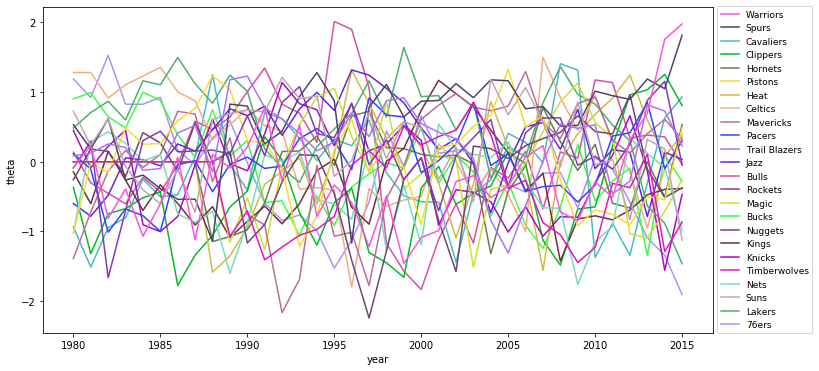

In [273]:
T, n = beta_path.shape
year = np.arange(1980,2015 + 1)
f = plt.figure(1, figsize = (12,6))

for i in range(n):
    plt.plot(year, beta_path[:,i], label=teams[i], color = np.random.rand(3,))
plt.xlabel("year")
plt.ylabel("theta")
plt.ticklabel_format(style='plain',axis='x',useOffset=False)

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = np.argsort(-beta_path[-1])
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='center left',bbox_to_anchor=(1, 0, 0, 1),prop={'size': 9}) 
# plt.legend(loc='center left', bbox_to_anchor=(1, 1, 1, 0),prop={'size': 11.3})
plt.savefig('theta_path_2.pdf', bbox_inches='tight')

## Check the GLR path

In [257]:
def draw_glr_path(X_train, Y_train, smooth, step):
    T = len(Y_train)
    lam = 0.1

    l_left, l_right = glr_path(Y_train, X_train, 0, T - 1, smooth = smooth, step = step, lam = lam)

    beta_joint, loglike_joint = likelihood_interval(Y_train, X_train, 0, T - 1, lam = lam)

    beta_left, loglike_left, sample_size_left = l_left
    beta_right, loglike_right, sample_size_right = l_right

    loglike_split = loglike_left + loglike_right

    return sample_size_left, loglike_split - loglike_joint

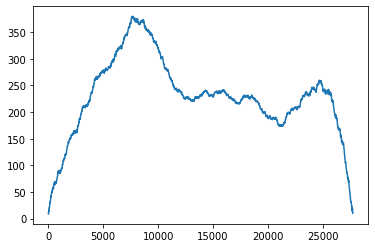

In [258]:
path_t_all, path_loglike_all = draw_glr_path(X, Y, smooth = 16, step = 10)
plt.plot(path_t_all, path_loglike_all)
plt.savefig('nba_glr_all_2.pdf', bbox_inches='tight')

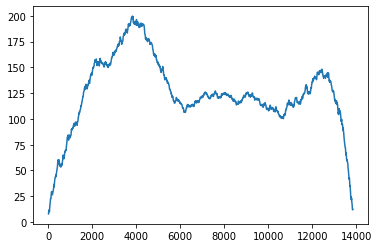

In [282]:
T = len(Y)
X_train, Y_train = X[0:T:2], Y[0:T:2]

path_t_odd, path_loglike_odd = draw_glr_path(X_train, Y_train, smooth = 16, step = 10)
plt.plot(path_t_odd, path_loglike_odd)
plt.savefig('nba_glr_odd_2.pdf', bbox_inches='tight')

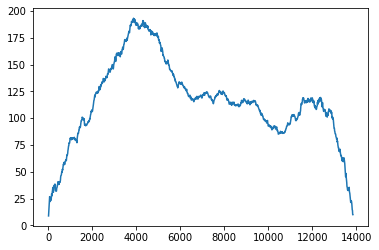

In [284]:
T = len(Y)
X_test, Y_test = X[1:T:2], Y[1:T:2]

path_t_even, path_loglike_even = draw_glr_path(X_test, Y_test, smooth = 16, step = 10)
plt.plot(path_t_even, path_loglike_even)
plt.savefig('nba_glr_even_2.pdf', bbox_inches='tight')

## Fit DPLR

In [223]:
def fit_bt_with_cp(cp):
    K = len(cp) - 1
    p = X.shape[1]
    beta_path = np.zeros((K, p))
    lam = 0.1

    for i in range(K):
        X_cur = X[cp[i]:cp[i + 1]]
        Y_cur = Y[cp[i]:cp[i + 1]]
    
        beta_cur = bt_fit(Y_cur, X_cur, lam).reshape((-1,))
        beta_path[i] = beta_cur.copy()    

    score_all = pd.DataFrame({'team':teams, 'theta_all':np.round(beta_all, 4)}).sort_values(by = 'theta_all', ascending=False, ignore_index=True)

    for i in range(K):
        score_cur = pd.DataFrame({('team_' + str(i)):teams, ('theta_' + str(i)):np.round(beta_path[i], 4)}).sort_values(by = 'theta_' + str(i), ascending=False, ignore_index=True)
        score_all = pd.concat([score_all, score_cur], axis = 1)
    return score_all

In [219]:
gamma_list = [60]
lam_list = [0.1]
grid_n = 100

T = len(Y)
X_train, Y_train = X[0:T:2], Y[0:T:2]
X_test, Y_test = X[1:T:2], Y[1:T:2]

start_time = time.time()
dplr_fit = dplr_cv_bt(grid_n, lam_list, gamma_list, smooth = 10, buffer = 5, step_refine = 10)
cp_best, param_best, cp_best_cand = dplr_fit.fit((Y_train, X_train), (Y_test, X_test))
run_time_dc = time.time() - start_time

print("cp: {0}".format(cp_best))
print("param: {0}".format(param_best))
print("avg time: {0}".format(run_time_dc))

cp: [2120, 4298, 7072, 9284, 10450, 11712, 12732]
param: (0.1, 60)
avg time: 61.64626383781433


In [220]:
cp = cp_best.copy()
cp = [x * 2 for x in cp]
cp = [0] + cp + [len(games) - 1]
games.iloc[cp]

,season,game_id,team_A_name,team_B_name,team_A_pts,team_B_pts
0,1980-81,28000001,Suns,Warriors,121,101
4240,1986-87,28600005,Kings,Clippers,107,106
8596,1991-92,29100536,Timberwolves,Pistons,100,111
14144,1998-99,29800105,Jazz,Nuggets,97,86
18568,2003-04,20301151,Heat,Cavaliers,80,91
20900,2006-07,20601177,Knicks,Nets,86,100
23424,2010-11,21000239,Heat,Mavericks,95,106
25464,2012-13,21201230,Trail Blazers,Warriors,88,99
27735,2015-16,21501230,Trail Blazers,Nuggets,107,99


In [221]:
gamma_list = [80]
lam_list = [0.1]
grid_n = 100

T = len(Y)
X_train, Y_train = X[0:T:2], Y[0:T:2]
X_test, Y_test = X[1:T:2], Y[1:T:2]

start_time = time.time()
dplr_fit = dplr_cv_bt(grid_n, lam_list, gamma_list, smooth = 10, buffer = 5, step_refine = 10)
cp_best, param_best, cp_best_cand = dplr_fit.fit((Y_train, X_train), (Y_test, X_test))
run_time_dc = time.time() - start_time

print("cp: {0}".format(cp_best))
print("param: {0}".format(param_best))
print("avg time: {0}".format(run_time_dc))

cp: [3848, 7078, 10454, 12364]
param: (0.1, 80)
avg time: 48.31383180618286


In [222]:
gamma_list = [100]
# gamma_list = [1, 2]
lam_list = [0.1]
grid_n = 100

T = len(Y)
X_train, Y_train = X[0:T:2], Y[0:T:2]
X_test, Y_test = X[1:T:2], Y[1:T:2]

start_time = time.time()
dplr_fit = dplr_cv_bt(grid_n, lam_list, gamma_list, smooth = 10, buffer = 5, step_refine = 10)
cp_best, param_best, cp_best_cand = dplr_fit.fit((Y_train, X_train), (Y_test, X_test))
run_time_dc = time.time() - start_time

print("cp: {0}".format(cp_best))
print("param: {0}".format(param_best))
print("avg time: {0}".format(run_time_dc))

cp: [3848, 7078, 10454, 12364]
param: (0.1, 100)
avg time: 45.75070071220398


In [226]:
gamma_list = [40, 60, 80, 100]
# gamma_list = [1, 2]
lam_list = [0.1]
grid_n = 100

T = len(Y)
X_train, Y_train = X[0:T:2], Y[0:T:2]
X_test, Y_test = X[1:T:2], Y[1:T:2]

start_time = time.time()
dplr_fit = dplr_cv_bt(grid_n, lam_list, gamma_list, smooth = 10, buffer = 5, step_refine = 10)
cp_best, param_best, cp_best_cand = dplr_fit.fit((Y_train, X_train), (Y_test, X_test))
run_time_dc = time.time() - start_time

print("cp: {0}".format(cp_best))
print("param: {0}".format(param_best))
print("avg time: {0}".format(run_time_dc))

cp: [2120, 4298, 7072, 9284, 10450, 11712, 12732]
param: (0.1, 60)
avg time: 156.93847632408142


In [227]:
cp = cp_best
cp.sort()
cp = [x * 2 for x in cp]
cp = [0] + cp + [len(games) - 1]

In [228]:
cp

[0, 4240, 8596, 14144, 18568, 20900, 23424, 25464, 27735]

In [229]:
games.iloc[cp]

,season,game_id,team_A_name,team_B_name,team_A_pts,team_B_pts
0,1980-81,28000001,Suns,Warriors,121,101
4240,1986-87,28600005,Kings,Clippers,107,106
8596,1991-92,29100536,Timberwolves,Pistons,100,111
14144,1998-99,29800105,Jazz,Nuggets,97,86
18568,2003-04,20301151,Heat,Cavaliers,80,91
20900,2006-07,20601177,Knicks,Nets,86,100
23424,2010-11,21000239,Heat,Mavericks,95,106
25464,2012-13,21201230,Trail Blazers,Warriors,88,99
27735,2015-16,21501230,Trail Blazers,Nuggets,107,99


In [230]:
score_all = fit_bt_with_cp(cp)
score_all

,team,theta_all,team_0,theta_0,team_1,theta_1,team_2,theta_2,team_3,theta_3,team_4,theta_4,team_5,theta_5,team_6,theta_6,team_7,theta_7
0,Lakers,0.5203,Celtics,1.1484,Lakers,1.1033,Bulls,0.9666,Spurs,0.8910,Spurs,1.0532,Lakers,1.0097,Heat,0.9909,Warriors,1.3617
1,Spurs,0.5006,76ers,0.9851,Pistons,0.7696,Jazz,0.8618,Lakers,0.8744,Suns,0.9559,Celtics,0.8699,Spurs,0.8653,Spurs,1.2728
2,Jazz,0.2682,Bucks,0.7828,Celtics,0.7304,Knicks,0.5908,Kings,0.6833,Mavericks,0.9338,Magic,0.7741,Bulls,0.8292,Clippers,0.9909
3,Trail Blazers,0.2571,Lakers,0.7779,Trail Blazers,0.6848,Suns,0.5628,Mavericks,0.5087,Pistons,0.8120,Cavaliers,0.7466,Nuggets,0.5857,Rockets,0.6158
4,Suns,0.2478,Nuggets,0.0789,Bulls,0.6647,Rockets,0.5032,Trail Blazers,0.4899,Heat,0.2713,Spurs,0.6270,Lakers,0.4922,Trail Blazers,0.5501
5,Rockets,0.1991,Trail Blazers,0.0636,Jazz,0.5179,Spurs,0.4742,Jazz,0.3944,Rockets,0.1803,Mavericks,0.5686,Mavericks,0.4121,Mavericks,0.4197
6,Celtics,0.1956,Suns,0.0636,Bucks,0.3474,Trail Blazers,0.4176,Timberwolves,0.3913,Cavaliers,0.1510,Jazz,0.5169,Clippers,0.3413,Cavaliers,0.3872
7,Bulls,0.0826,Spurs,0.0611,Suns,0.3472,Cavaliers,0.3751,Pacers,0.3165,Nuggets,0.1322,Nuggets,0.4751,Celtics,0.2901,Heat,0.3215
8,Pistons,0.0389,Nets,0.0215,Rockets,0.3156,Magic,0.3009,Hornets,0.1002,Kings,0.0542,Suns,0.4146,Knicks,0.1990,Pacers,0.3202
9,Mavericks,0.0331,Timberwolves,0.0000,76ers,0.2195,Lakers,0.2730,76ers,0.0993,Lakers,0.0166,Hornets,0.3593,Pacers,0.1233,Bulls,0.2104


In [239]:
ix = np.where(games['season'].values == '1991-92')[0]
df = games.iloc[ix]
df

,season,game_id,team_A_name,team_B_name,team_A_pts,team_B_pts
8176,1991-92,29100001,Kings,Clippers,94,90
8177,1991-92,29100002,Spurs,Mavericks,140,99
8178,1991-92,29100003,Magic,Knicks,106,96
8179,1991-92,29100004,Bulls,76ers,110,90
8180,1991-92,29100005,Celtics,Hornets,111,108
...,...,...,...,...,...,...
9040,1991-92,29101102,Celtics,Heat,109,93
9041,1991-92,29101104,Spurs,Jazz,90,101
9042,1991-92,29101105,Timberwolves,Hornets,130,107
9043,1991-92,29101106,Lakers,Clippers,109,108


In [240]:
ix = np.where(df['game_id'].values == 29100536)[0]
df.iloc[ix]

,season,game_id,team_A_name,team_B_name,team_A_pts,team_B_pts
8596,1991-92,29100536,Timberwolves,Pistons,100,111
